
# TAF — Fase 1: Análisis y preparación de los datos (Book-Crossing)

Notebook regenerado para apuntar a tu ruta local de datos:

```
E:\proyectos\MaestriaIAA\SistemasDeRecomendacion\mnt\data
```

**Objetivos de la Fase 1**  
- Descripción del dataset (usuarios, ítems, ratings, *sparsity*).  
- Visualizaciones (distribución de ratings, actividad de usuarios, popularidad de ítems).  
- Filtro de actividad mínima (≥ 10).  
- Construcción de **matriz de utilidad (CSR)** y guardado para Fase 2.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.sparse import csr_matrix

# 👉 Ajusta aquí tu ruta si la cambias en el futuro
DATA_DIR = Path(r"E:\proyectos\MaestriaIAA\SistemasDeRecomendacion\mnt\data")
OUTPUT_DIR = DATA_DIR / "fase1_outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Usando DATA_DIR =", DATA_DIR.resolve())
print("Salidas en     =", OUTPUT_DIR.resolve())
print("Versión pandas:", pd.__version__)


Usando DATA_DIR = E:\proyectos\MaestriaIAA\SistemasDeRecomendacion\mnt\data
Salidas en     = E:\proyectos\MaestriaIAA\SistemasDeRecomendacion\mnt\data\fase1_outputs
Versión pandas: 2.3.3


## 0. Comprobación rápida de archivos

In [2]:

for p in sorted(DATA_DIR.glob("*")):
    size = f"{p.stat().st_size/1e6:.1f} MB" if p.is_file() else "dir"
    print(p.name, "|", size)


BX-Book-Ratings.csv | 30.7 MB
BX-Users.csv | 12.3 MB
BX_Books.csv | 77.4 MB
fase1_outputs | dir
Preprocessed_data.csv | 479.9 MB


## 1. Carga del dataset

In [3]:

def _first_existing(*paths):
    from pathlib import Path
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

def _read_any(path):
    import pandas as pd
    for sep in [';', ',', '\t']:
        try:
            df = pd.read_csv(path, sep=sep, encoding='latin-1', low_memory=False, engine='python')
            if df.shape[1] >= 3:
                return df
        except Exception:
            pass
    return pd.read_csv(path, low_memory=False)

def load_bookcrossing():
    import pandas as pd
    raw_context = {}

    pre = DATA_DIR / "Preprocessed_data.csv"
    if pre.exists():
        df = pd.read_csv(pre, low_memory=False)
        lower = {c.lower(): c for c in df.columns}
        u = next((lower[k] for k in ['user-id','user_id','user','userid'] if k in lower), None)
        i = next((lower[k] for k in ['isbn','item_id','book','bookid'] if k in lower), None)
        r = next((lower[k] for k in ['book-rating','rating','rate','score'] if k in lower), None)
        assert u and i and r, "No se detectaron columnas user/item/rating en Preprocessed_data.csv"
        ratings_df = df[[u,i,r]].copy()
        ratings_df.columns = ['user_id','item_id','rating']
        return ratings_df, raw_context, 'Preprocessed_data.csv'

    bx_ratings = _first_existing(DATA_DIR/'BX-Book-Ratings.csv', DATA_DIR/'BX_Book-Ratings.csv')
    bx_users   = _first_existing(DATA_DIR/'BX-Users.csv', DATA_DIR/'BX_Users.csv')
    bx_books   = _first_existing(DATA_DIR/'BX_Books.csv', DATA_DIR/'BX-Books.csv')

    if bx_ratings and bx_ratings.exists():
        r_df = _read_any(bx_ratings)
        low = {c.lower(): c for c in r_df.columns}
        u = low.get('user-id') or low.get('user_id') or low.get('userid') or list(r_df.columns)[0]
        i = low.get('isbn') or low.get('item_id') or list(r_df.columns)[1]
        r = low.get('book-rating') or low.get('rating') or list(r_df.columns)[2]
        ratings_df = r_df[[u,i,r]].copy()
        ratings_df.columns = ['user_id','item_id','rating']

        if bx_users is not None and bx_users.exists():
            raw_context['users'] = _read_any(bx_users)
        if bx_books is not None and bx_books.exists():
            raw_context['books'] = _read_any(bx_books)

        return ratings_df, raw_context, f'BX (ratings: {{bx_ratings.name}})'
    
    raise FileNotFoundError(f"No se encontraron archivos válidos en {{DATA_DIR}}")

ratings_df, context, origin = load_bookcrossing()
ratings_df['user_id'] = ratings_df['user_id'].astype(str)
ratings_df['item_id'] = ratings_df['item_id'].astype(str)
ratings_df['rating']  = pd.to_numeric(ratings_df['rating'], errors='coerce')
ratings_df = ratings_df.dropna(subset=['user_id','item_id','rating'])

print('Origen:', origin, '| shape:', ratings_df.shape)
ratings_df.head()


Origen: Preprocessed_data.csv | shape: (1031175, 3)


,user_id,item_id,rating
0,2,0195153448,0
1,8,0002005018,5
2,11400,0002005018,0
3,11676,0002005018,8
4,41385,0002005018,0


## 2. Estadísticas globales y *sparsity*

In [4]:

n_ratings = len(ratings_df)
n_users   = ratings_df['user_id'].nunique()
n_items   = ratings_df['item_id'].nunique()
sparsity  = 1 - (n_ratings / (n_users * n_items))

summary = pd.DataFrame({
    'fuente':[origin],
    'n_usuarios':[n_users],
    'n_libros':[n_items],
    'n_ratings':[n_ratings],
    'sparsity':[sparsity]
})
summary


,fuente,n_usuarios,n_libros,n_ratings,sparsity
0,Preprocessed_data.csv,92107,270170,1031175,0.999959


## 3. Visualizaciones de distribución y actividad

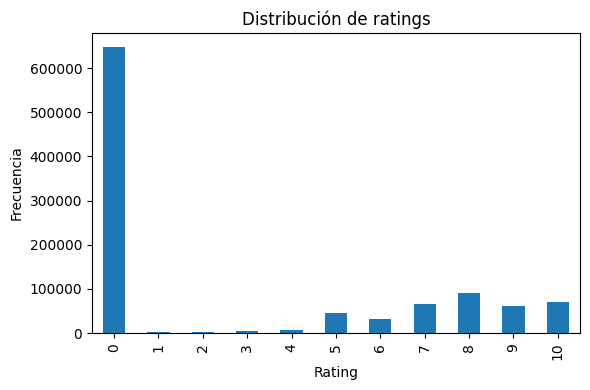

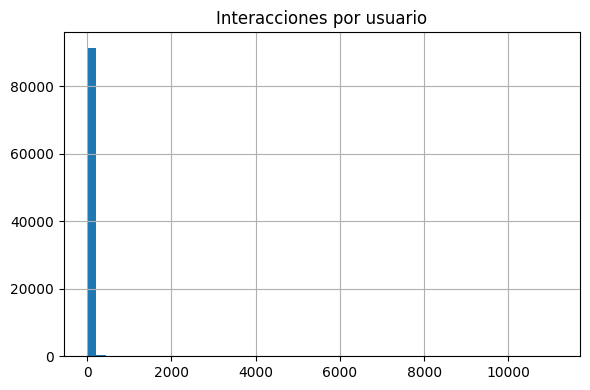

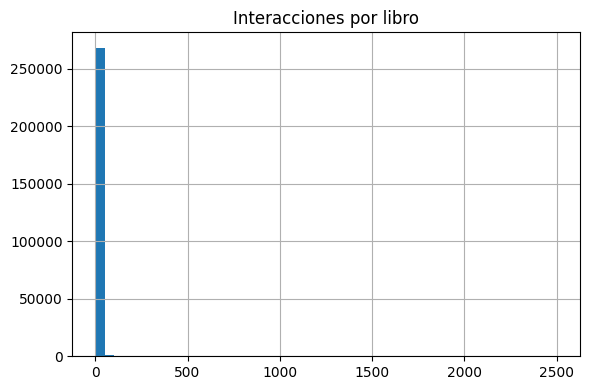

In [5]:

ratings_df['rating'].value_counts().sort_index().plot(kind='bar', figsize=(6,4))
plt.title('Distribución de ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

user_activity = ratings_df.groupby('user_id')['item_id'].count().rename('n_interacciones')
item_pop      = ratings_df.groupby('item_id')['user_id'].count().rename('n_interacciones')

user_activity.hist(bins=50, figsize=(6,4))
plt.title('Interacciones por usuario')
plt.tight_layout()
plt.show()

item_pop.hist(bins=50, figsize=(6,4))
plt.title('Interacciones por libro')
plt.tight_layout()
plt.show()


## 4. Filtrado por actividad mínima (≥ 10)

In [6]:

MIN_INTERACCIONES = 10
ua = ratings_df.groupby('user_id')['item_id'].count().rename('n_interacciones').reset_index()
ia = ratings_df.groupby('item_id')['user_id'].count().rename('n_interacciones').reset_index()

usuarios_validos = ua[ua['n_interacciones'] >= MIN_INTERACCIONES]['user_id']
items_validos    = ia[ia['n_interacciones'] >= MIN_INTERACCIONES]['item_id']

filtered = ratings_df[ratings_df['user_id'].isin(usuarios_validos) & ratings_df['item_id'].isin(items_validos)].copy()

n_ratings_f = len(filtered)
n_users_f   = filtered['user_id'].nunique()
n_items_f   = filtered['item_id'].nunique()
sparsity_f  = 1 - (n_ratings_f / (n_users_f * n_items_f))

summary_f = pd.DataFrame({
    'min_interacciones':[MIN_INTERACCIONES],
    'n_usuarios_filtrados':[n_users_f],
    'n_libros_filtrados':[n_items_f],
    'n_ratings_filtrados':[n_ratings_f],
    'sparsity_filtrado':[sparsity_f]
})
summary_f


,min_interacciones,n_usuarios_filtrados,n_libros_filtrados,n_ratings_filtrados,sparsity_filtrado
0,10,11598,17478,428085,0.997888


## 5. Matriz de utilidad (CSR)

In [7]:

user_index = {u:i for i,u in enumerate(filtered['user_id'].unique())}
item_index = {m:i for i,m in enumerate(filtered['item_id'].unique())}

rows = filtered['user_id'].map(user_index).values
cols = filtered['item_id'].map(item_index).values
vals = filtered['rating'].values.astype(float)

R = csr_matrix((vals, (rows, cols)), shape=(len(user_index), len(item_index)))
print('Matriz R (usuarios x ítems):', R.shape, '| nnz:', R.nnz)


Matriz R (usuarios x ítems): (11598, 17478) | nnz: 428085


## 6. Guardado para Fase 2

In [8]:

filtered.to_csv(OUTPUT_DIR / 'ratings_filtrado_min10.csv', index=False)
pd.Series(user_index).to_csv(OUTPUT_DIR / 'map_user_index.csv', header=['idx'])
pd.Series(item_index).to_csv(OUTPUT_DIR / 'map_item_index.csv', header=['idx'])
print('Guardado en:', OUTPUT_DIR.resolve())


Guardado en: E:\proyectos\MaestriaIAA\SistemasDeRecomendacion\mnt\data\fase1_outputs
